In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import torch

import pennylane as qml
from pennylane import numpy as qnp

from PIL import Image

import time
import warnings
warnings.filterwarnings("ignore")

## Extracting Hearts Image

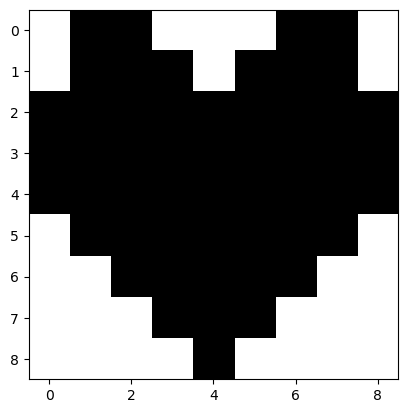

In [2]:
img = Image.open("/Users/akashmalemath/Documents/master_work/qcbm_hiwi/qcbm_project/bars_stripes_cat/heart_template.png").convert("L")
img = torch.tensor(np.array(img))/255.0
plt.imshow(img, cmap='gray')

In [3]:
img = img.flatten()
# img = (img > 0.5).int()
norm_img = img / torch.linalg.norm(img)

## Getting Wavefunction of Dataset

In [22]:
n_qubits = math.ceil(math.log2(img.shape[0]))
n_ancillas = 2
total_qubits = n_qubits + n_ancillas

In [23]:
padded_wavefunction = torch.zeros(2**n_qubits)
padded_wavefunction[:norm_img.shape[0]] = norm_img

In [24]:
target_dm = torch.einsum("i,j -> ij", padded_wavefunction, padded_wavefunction)
target_dm.shape

torch.Size([128, 128])

In [57]:
def encode_conditional_state_with_ancilla_last(psi1):
    """
    Construct a 9-qubit state where:
      - psi1 is conditioned on ancilla |00⟩
      - psi2 is conditioned on ancilla |01⟩
    Ancillas are the **last two qubits**.
    """
    assert psi1.shape[0] == 2**n_qubits #and psi2.shape[0] == 128

    psi_full = torch.zeros(2**total_qubits, dtype=torch.complex64)

    for i in range(2**n_qubits):
        base_index = i * 4  # because 2^2 = 4 ancilla states
        psi_full[base_index + 0] = psi1[i]  # |00⟩ ancilla
        # psi_full[base_index + 1] = psi2[i]  # |01⟩ ancilla
        # base_index + 2 and +3 remain 0 (for |10⟩ and |11⟩)
    
    return psi_full


In [58]:
##### For training over the register basis
# full_padded_wavefunction = torch.zeros(2**total_qubits)
full_padded_wavefunction = encode_conditional_state_with_ancilla_last(padded_wavefunction)

target_full_dm = torch.einsum("i,j -> ij", full_padded_wavefunction, full_padded_wavefunction)
target_full_dm.shape

torch.Size([512, 512])

## Functions

In [26]:
from pennylane.math import reduce_statevector

def sqrtm_torch(matrix:torch.Tensor) -> torch.Tensor:

    eigvals, eigvecs = torch.linalg.eig(matrix)
    eigvals = torch.sqrt(eigvals)
    return eigvecs @ torch.diag(eigvals) @ torch.linalg.inv(eigvecs)


def trdistance_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    
    pxy = px - py
    pxy_2 = pxy @ pxy
    dagger_pxy2 = pxy_2.conj().T
    tr_distance = 0.5 * torch.trace(sqrtm_torch(dagger_pxy2 @ pxy_2))
    return tr_distance.real



def qcbm(circuit_fn, params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):

    full_psi = circuit_fn(params)
    px = reduce_statevector(full_psi, indices=range(num_qubits))
    loss = trdistance_loss(px, py)
    return loss


In [27]:
def qcbm_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=i)

    for i in range(total_qubits-1):
        qml.IsingXY(ising_params1[i],wires=[i,i+1])
    qml.IsingXY(ising_params1[-1],wires=[total_qubits-1,0])

    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params2[i],wires=[i,i+1])
    qml.IsingZZ(ising_params2[-1],wires=[total_qubits-1,0])


dev = qml.device("default.qubit",wires=total_qubits)
folds = 3

@qml.qnode(dev,interface="torch")
def circuit(input_params,folds=folds,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):

    for i in range(total_qubits):

        ## 1010.... initial state
        if i%2 == 0:
            qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=input_params[i],total_qubits=total_qubits)
    
    output1 = qml.state()

    return output1


In [28]:
def fidelity_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    """
    Computes the fidelity loss between two quantum states.
    """
    px_dm = qml.math.dm_from_state_vector(px)

    return -1*qml.math.fidelity(px_dm,py) 

def vqc(circuit_fn,  params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):
    """
    Variational Quantum Circuit (VQC) function to compute the loss.
    """
    full_psi = circuit_fn(params)
    fid_loss = fidelity_loss(full_psi, py)
    return fid_loss.real

## Training the Model

In [29]:
initial_params = torch.rand((folds, 3 * total_qubits), requires_grad=True, dtype=torch.float32)

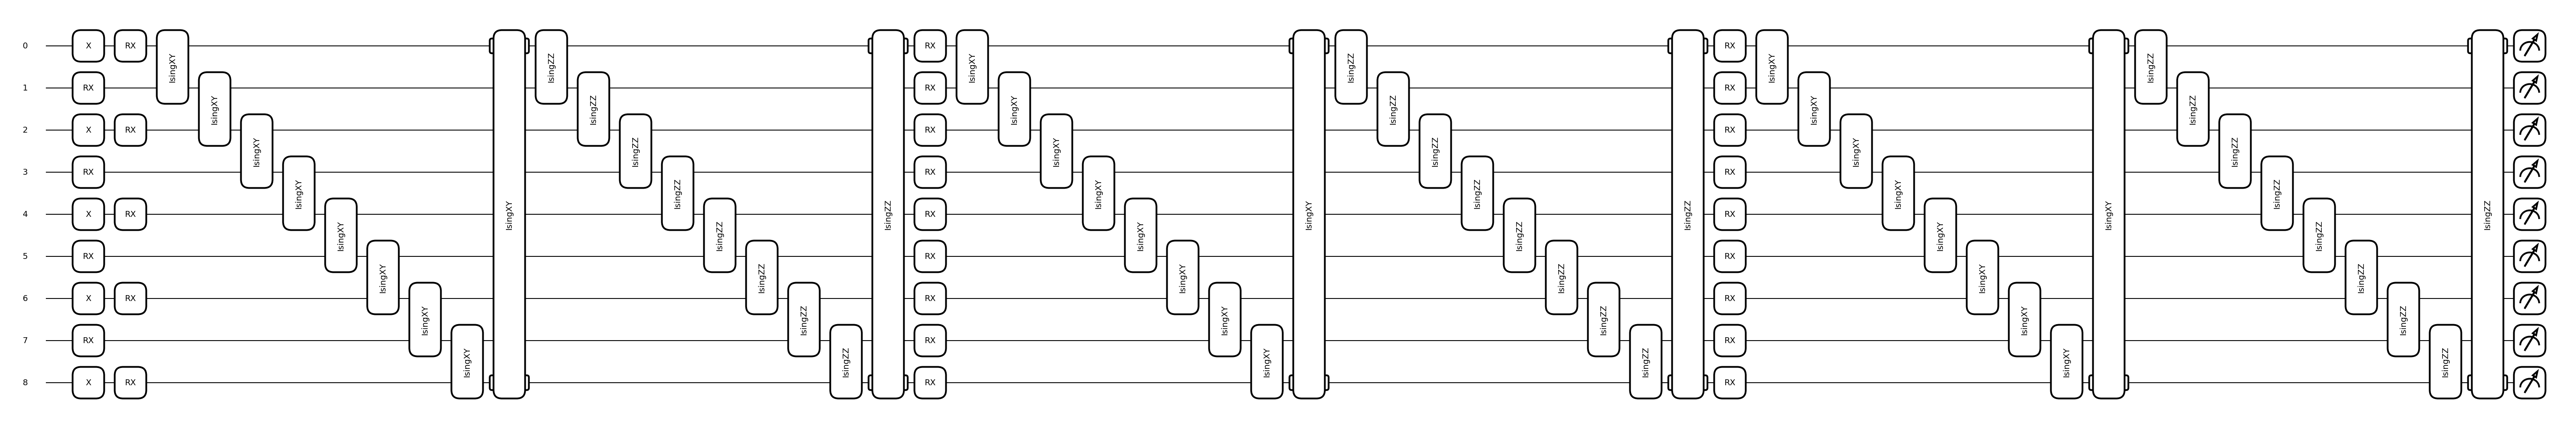

In [30]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show()

In [31]:
weights = initial_params
lr = 0.01
opt = torch.optim.Adam([weights], lr=lr)


loss_history = []
min_loss = qcbm(circuit, weights, target_dm)
optimal_params = torch.zeros((folds, 3* total_qubits), dtype=torch.float32)
n_epochs = 2000
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    opt.zero_grad()
    loss = qcbm(circuit, weights, target_dm)
    loss.backward()
    opt.step()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss} Time taken per iter: {end_time-start_time}")
    loss_history.append(loss.item())

    if loss < min_loss:
        min_loss = loss
        optimal_params = weights.detach().clone()


Step: 10 Loss: 0.6618851805304033 Time taken per iter: 0.028357982635498047
Step: 20 Loss: 0.6165116466237867 Time taken per iter: 0.02795696258544922
Step: 30 Loss: 0.5753304594594026 Time taken per iter: 0.02829909324645996
Step: 40 Loss: 0.5179091218076562 Time taken per iter: 0.02784419059753418
Step: 50 Loss: 0.4542020757148369 Time taken per iter: 0.027093887329101562
Step: 60 Loss: 0.4113398503801054 Time taken per iter: 0.027786970138549805
Step: 70 Loss: 0.3888973024720437 Time taken per iter: 0.02760481834411621
Step: 80 Loss: 0.37744849997680163 Time taken per iter: 0.027657032012939453
Step: 90 Loss: 0.37043310260518997 Time taken per iter: 0.026649951934814453
Step: 100 Loss: 0.3654333739308557 Time taken per iter: 0.02742290496826172
Step: 110 Loss: 0.36150988799316547 Time taken per iter: 0.027641773223876953
Step: 120 Loss: 0.3581605275568602 Time taken per iter: 0.02830195426940918
Step: 130 Loss: 0.3550641438191601 Time taken per iter: 0.028664827346801758
Step: 140 L

Text(0.5, 1.0, 'Loss Over Epochs')

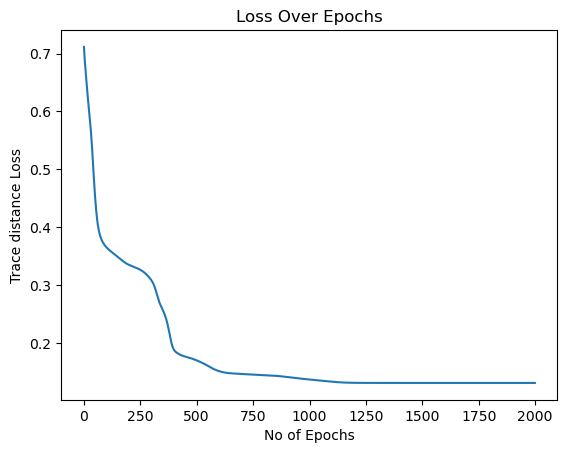

In [32]:
plt.plot(loss_history)
plt.xlabel("No of Epochs")
plt.ylabel("Trace distance Loss")
plt.title("Loss Over Epochs")

In [33]:
min_loss = loss_history[np.argmin(loss_history)]

print(f"The model converges to the Trace Distance Loss of {min_loss}")

The model converges to the Trace Distance Loss of 0.13075455529435817


In [34]:
psi = circuit(optimal_params)
reduced_dm = reduce_statevector(psi,indices=range(n_qubits))

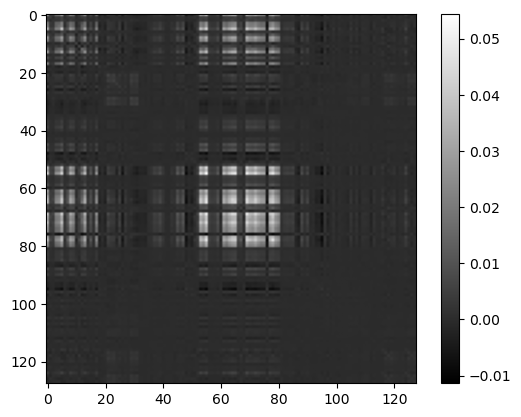

In [35]:
plt.imshow(reduced_dm.real,cmap="grey")
plt.colorbar()

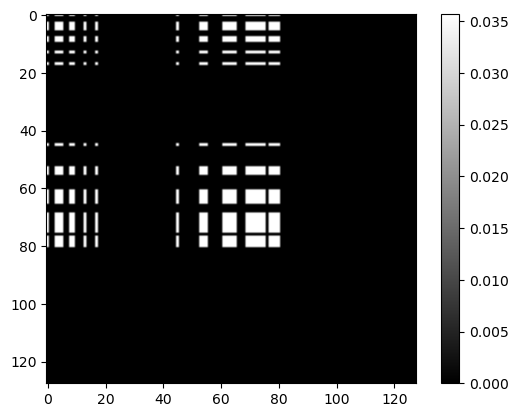

In [36]:
plt.imshow(target_dm.real,cmap="grey")
plt.colorbar()

## Training over the Register Basis

In [61]:
def vqc_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=n_qubits+i)

    for i in range(total_qubits-1):
        qml.IsingXY(ising_params1[i],wires=[n_qubits+i,n_qubits+i+1])
    # qml.IsingXY(ising_params1[-1],wires=[total_qubits-1,n_qubits])

    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params2[i],wires=[n_qubits+i,n_qubits+i+1])
    # qml.IsingZZ(ising_params2[-1],wires=[total_qubits-1,n_qubits])


dev = qml.device("default.qubit",wires=total_qubits)
folds = 3

@qml.qnode(dev,interface="torch")
def reg_circuit(input_params,trained_params=optimal_params,folds=folds,num_qubits=n_ancillas,total_qubits=total_qubits):
    
    for i in range(total_qubits):
        ## 1010.... initial state
        if i%2 == 0:
            qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=trained_params[i],total_qubits=total_qubits)

    for i in range(folds):
        vqc_circuit(params=input_params[i],total_qubits=n_ancillas)
    
    output = qml.state()

    return output


In [62]:
reg_params = torch.rand((folds, 3 * n_ancillas), requires_grad=True, dtype=torch.float32)

(<Figure size 7000x1000 with 1 Axes>, <Axes: >)

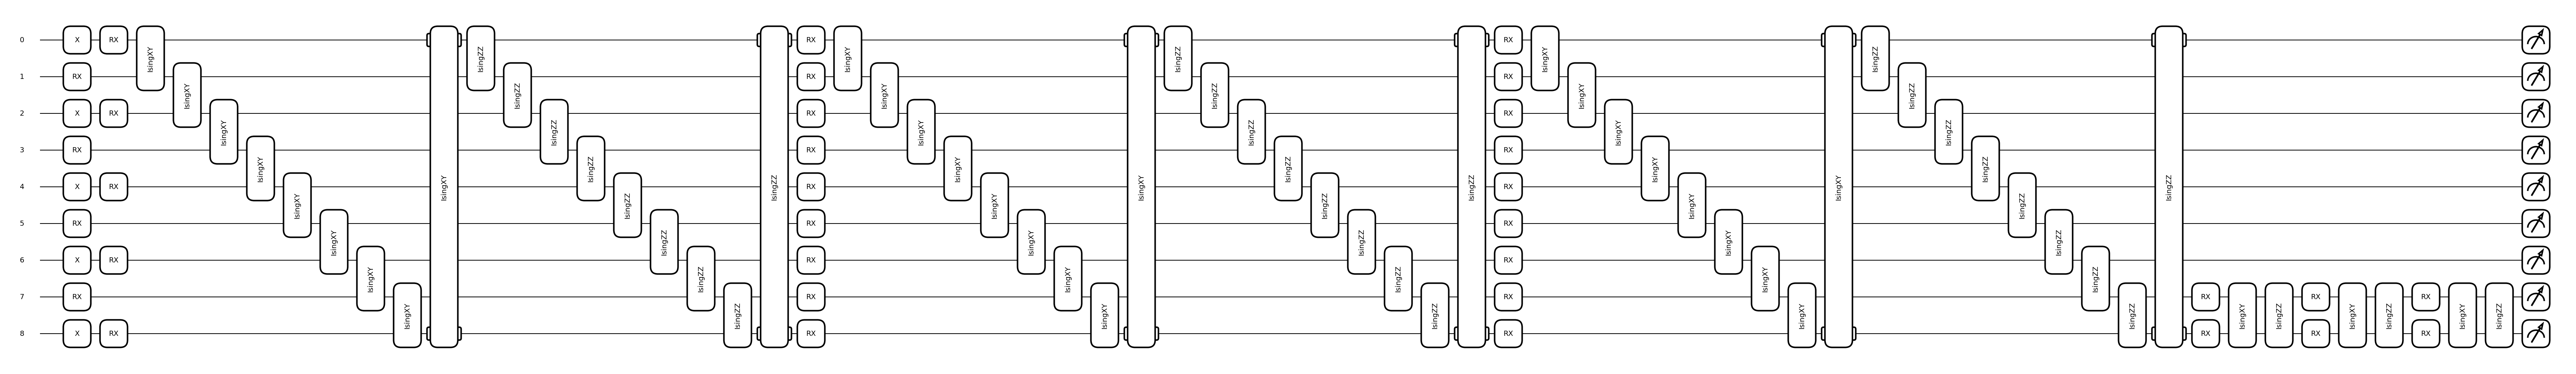

In [63]:
qml.draw_mpl(reg_circuit)(reg_params)

In [64]:
weights = reg_params
opt = torch.optim.Adam([weights], lr=0.01)

reg_loss_history = []
optimal_reg_params = torch.zeros((folds, 3 * n_ancillas), dtype=torch.float32)
min_loss = vqc(reg_circuit, weights, target_full_dm)
n_epochs = 500
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    opt.zero_grad()
    loss_val = vqc(reg_circuit, weights, target_full_dm)
    loss_val.backward()
    opt.step()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss_val} Time taken per iter: {end_time-start_time}")
    reg_loss_history.append(loss_val)

    if loss_val < min_loss:
        min_loss = loss_val
        optimal_reg_params = weights.detach().clone()


Step: 10 Loss: -0.4497214204802784 Time taken per iter: 0.38303685188293457
Step: 20 Loss: -0.6015862187995282 Time taken per iter: 0.3704109191894531
Step: 30 Loss: -0.6916909584752539 Time taken per iter: 0.3702700138092041
Step: 40 Loss: -0.7232143816198575 Time taken per iter: 0.37119603157043457
Step: 50 Loss: -0.7316385759961257 Time taken per iter: 0.3664257526397705
Step: 60 Loss: -0.7353157971986729 Time taken per iter: 0.36274003982543945
Step: 70 Loss: -0.736959015454849 Time taken per iter: 0.3587944507598877
Step: 80 Loss: -0.737948630031498 Time taken per iter: 0.3600788116455078
Step: 90 Loss: -0.7388478936146174 Time taken per iter: 0.3589749336242676
Step: 100 Loss: -0.7395629696900288 Time taken per iter: 0.40348124504089355
Step: 110 Loss: -0.7401098100114019 Time taken per iter: 0.3732893466949463
Step: 120 Loss: -0.7405421971319414 Time taken per iter: 0.36832189559936523
Step: 130 Loss: -0.7408940270914137 Time taken per iter: 0.37252259254455566
Step: 140 Loss: -

KeyboardInterrupt: 

In [65]:
full_psi = reg_circuit(optimal_reg_params)

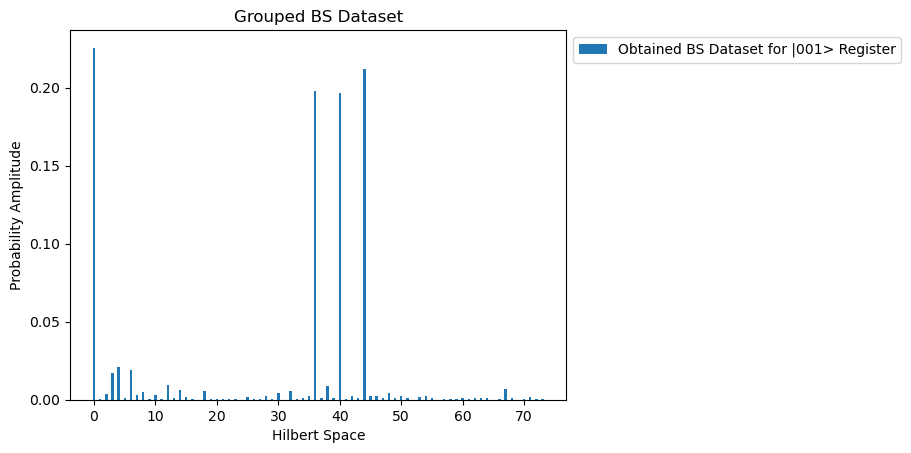

In [66]:
image = qnp.round(full_psi[::7],3)
image /= qnp.linalg.norm(image)

w, x = 0.4, np.arange(len(image))

# plt.bar(x - w/2, target_psi, w, label='Original BS Dataset')
plt.bar(x, np.abs(image)**2, w, label='Obtained BS Dataset for |001> Register')

plt.xlabel('Hilbert Space')
plt.ylabel('Probability Amplitude')
plt.title('Grouped BS Dataset')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

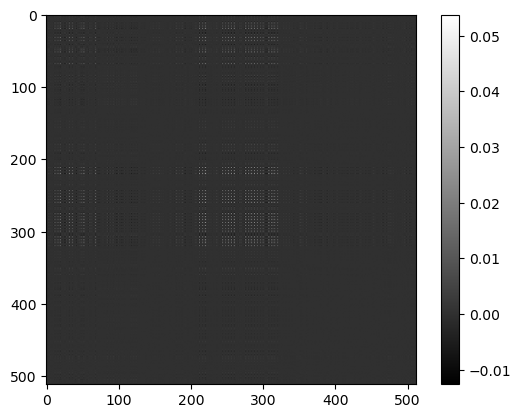

In [67]:
dm = qml.math.dm_from_state_vector(full_psi)
plt.imshow(dm.real,cmap="grey")
plt.colorbar()

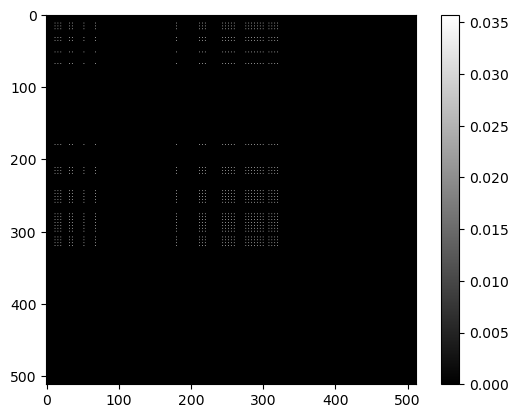

In [68]:
plt.imshow(target_full_dm.real,cmap="grey")
plt.colorbar()